# BI - Laboratorio 2
- Manuel Felipe Carvajal Parra 202014203
- Juanita Gil Arango 202111556

## 0. Imports

In [53]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

from sklearn.cluster import KMeans


## 1. Carga de datos

En esta sección se explica cómo se carga el conjunto de datos que se utilizará a lo largo del laboratorio. Se suele emplear la función pd.read_csv (o funciones similares) para leer archivos con formato CSV, Excel u otros, permitiendo convertir la información en un DataFrame de pandas. Así, se asegura que la data esté disponible para realizar análisis exploratorio, procesamiento y modelado posterior.

In [54]:
df = pd.read_csv("Datos_SenecaféAlpes.csv", sep=";", encoding="utf-8-sig")
print(df.columns[:5])

Index(['ID', 'Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor'], dtype='object')


## 2. Entendimiento de los datos

En esta sección se realiza un análisis exploratorio para obtener una visión general del conjunto de datos de los granos de café. El objetivo es identificar posibles problemas de calidad, detectar valores atípicos y entender la distribución de las variables numéricas. Estas visualizaciones permiten conocer el comportamiento de los datos antes de aplicar los algoritmos de agrupación.


### 2.1 Analisis numerico

A continuación se seleccionan las variables numéricas del dataset, que corresponden a las medidas geométricas y morfológicas de los granos de café. Estas variables serán la base para la aplicación de los algoritmos de agrupación, ya que contienen la información cuantitativa relevante.


In [55]:
numericas = [
    'Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor',
    'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida',
    'Solidez', 'Redondez', 'Compacidad',
    'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4'
]

print("Número de variables numéricas seleccionadas:", len(numericas))
print(numericas[:8], "...")


Número de variables numéricas seleccionadas: 15
['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida'] ...


##### 2.1.1. Gráficas de dispersión

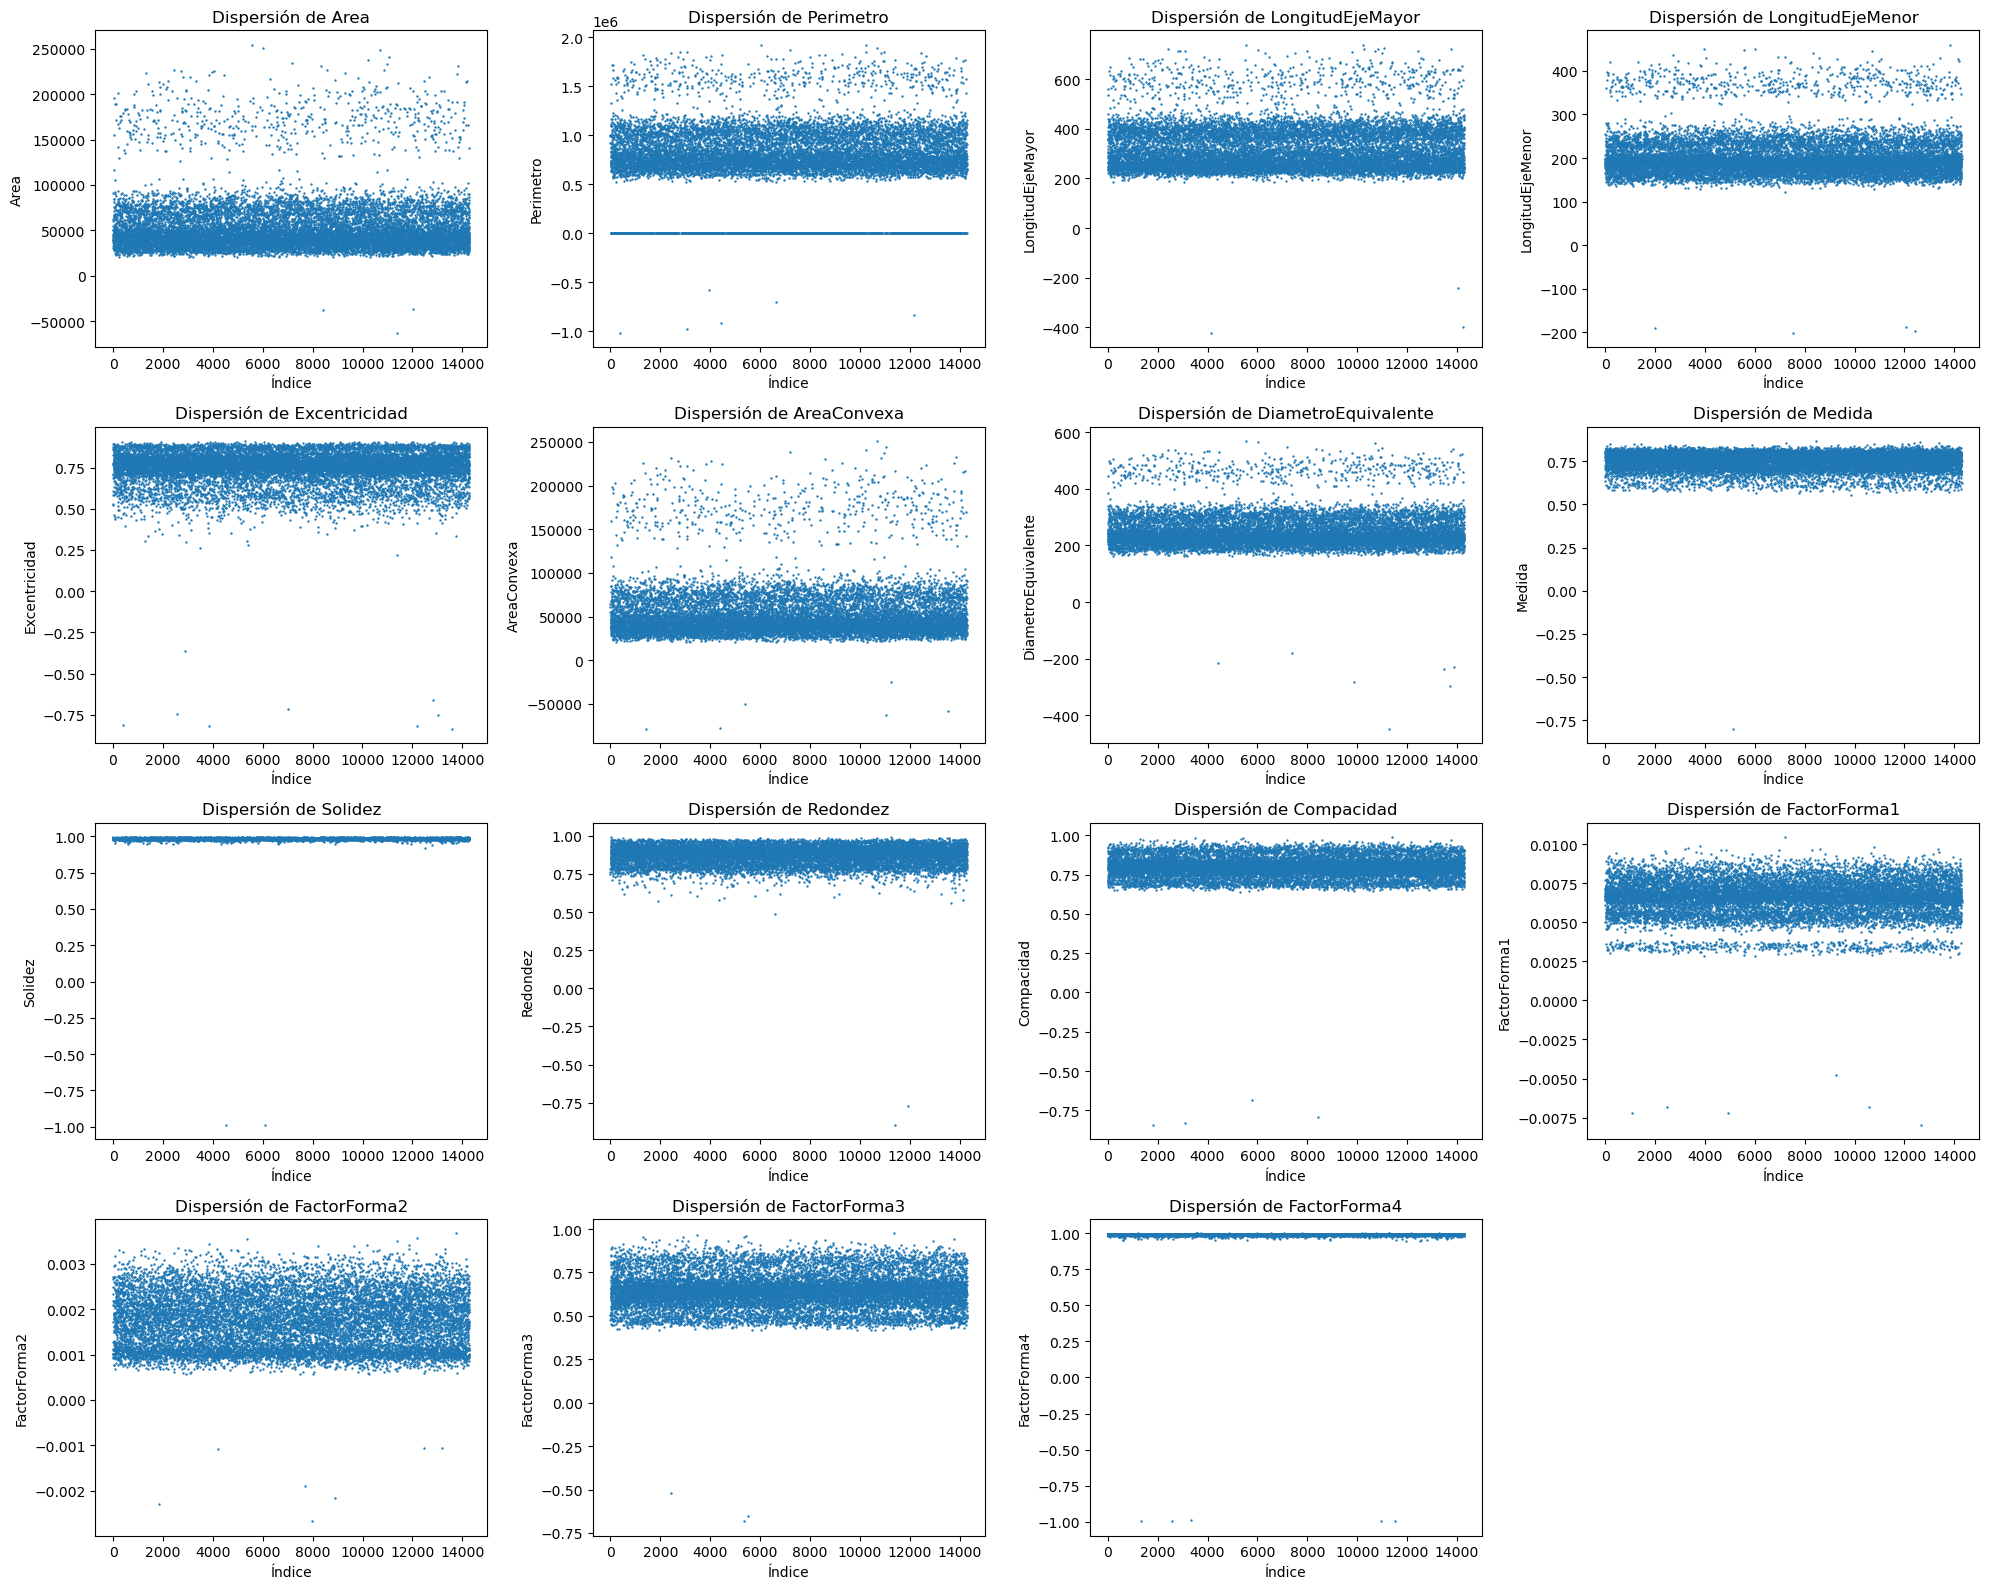

In [56]:
import math

columnas_por_fila = 4
filas = math.ceil(len(numericas) / columnas_por_fila)
fig, ejes = plt.subplots(filas, columnas_por_fila, figsize=(columnas_por_fila * 5, filas * 4))
ejes = ejes.flatten()

for eje, columna in zip(ejes, numericas):
    eje.scatter(df.index, df[columna], s=0.5)
    eje.set_xlabel("Índice")
    eje.set_ylabel(columna)
    eje.set_title(f"Dispersión de {columna}")

for eje in ejes[len(numericas):]:
    eje.set_visible(False)

plt.tight_layout()
plt.show()


##### 2.1.2 Histogramas

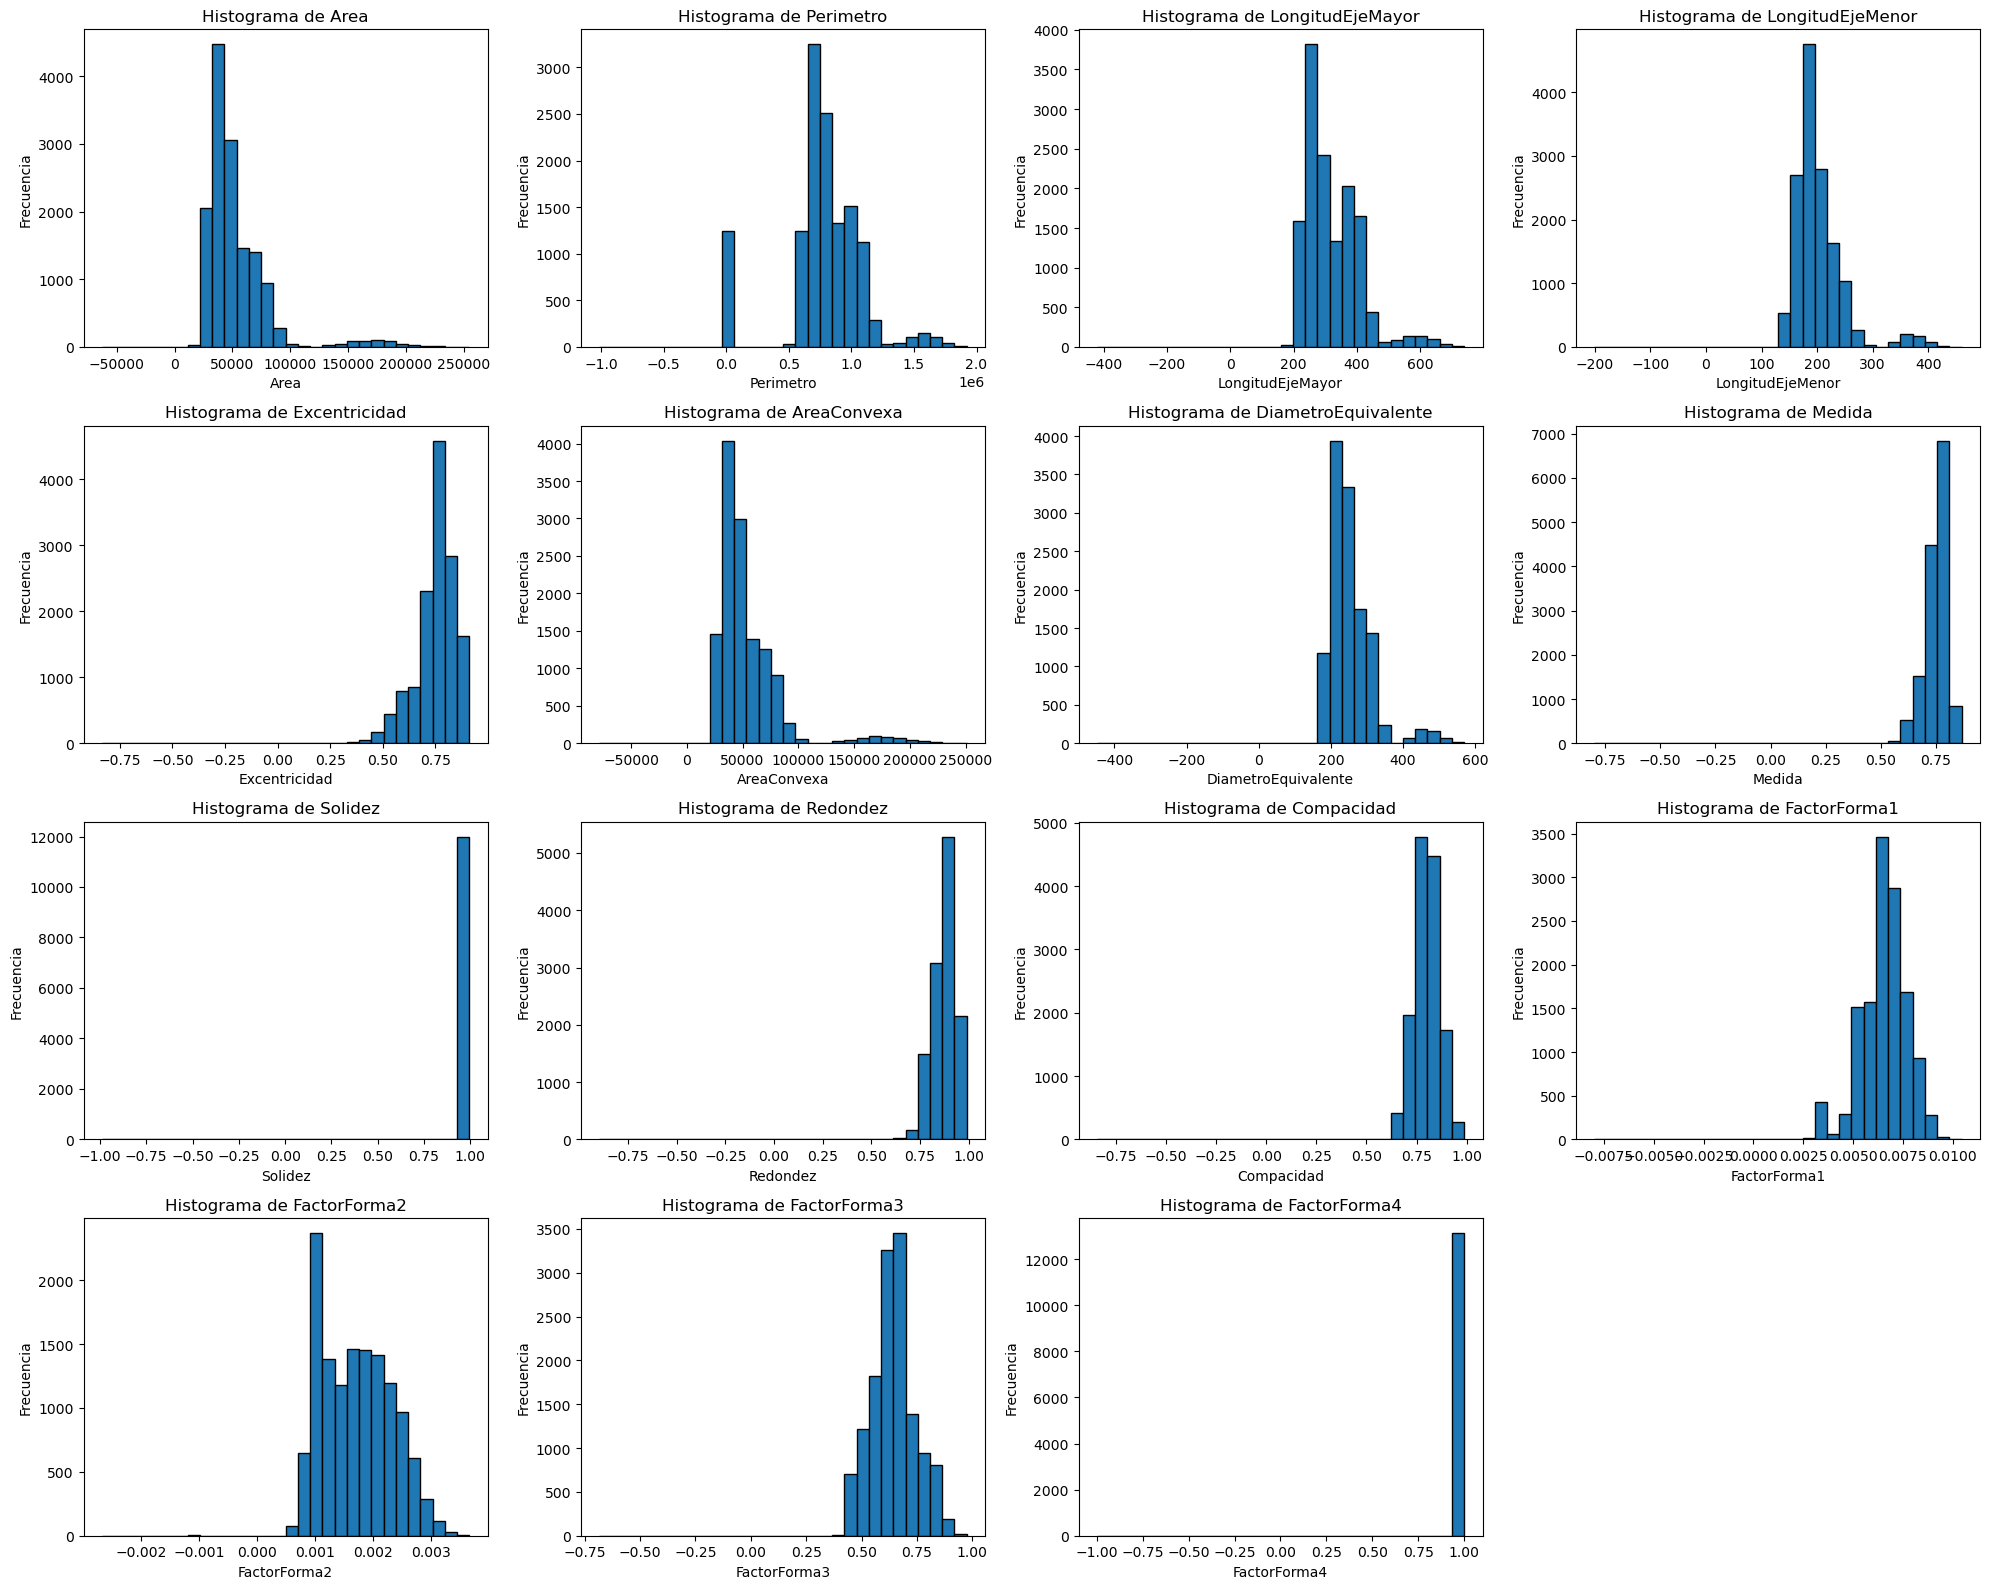

In [57]:
import math

columnas_por_fila = 4
filas_histo = math.ceil(len(numericas) / columnas_por_fila)

fig, axes_hist = plt.subplots(filas_histo, columnas_por_fila, figsize=(columnas_por_fila * 5, filas_histo * 4))
axes_hist = axes_hist.flatten()

for ax, col in zip(axes_hist, numericas):
    datos_col = df[col].dropna()
    ax.hist(datos_col, bins=30, edgecolor="black")
    ax.set_title(f"Histograma de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

for ax in axes_hist[len(numericas):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


##### 2.1.3 Boxplots

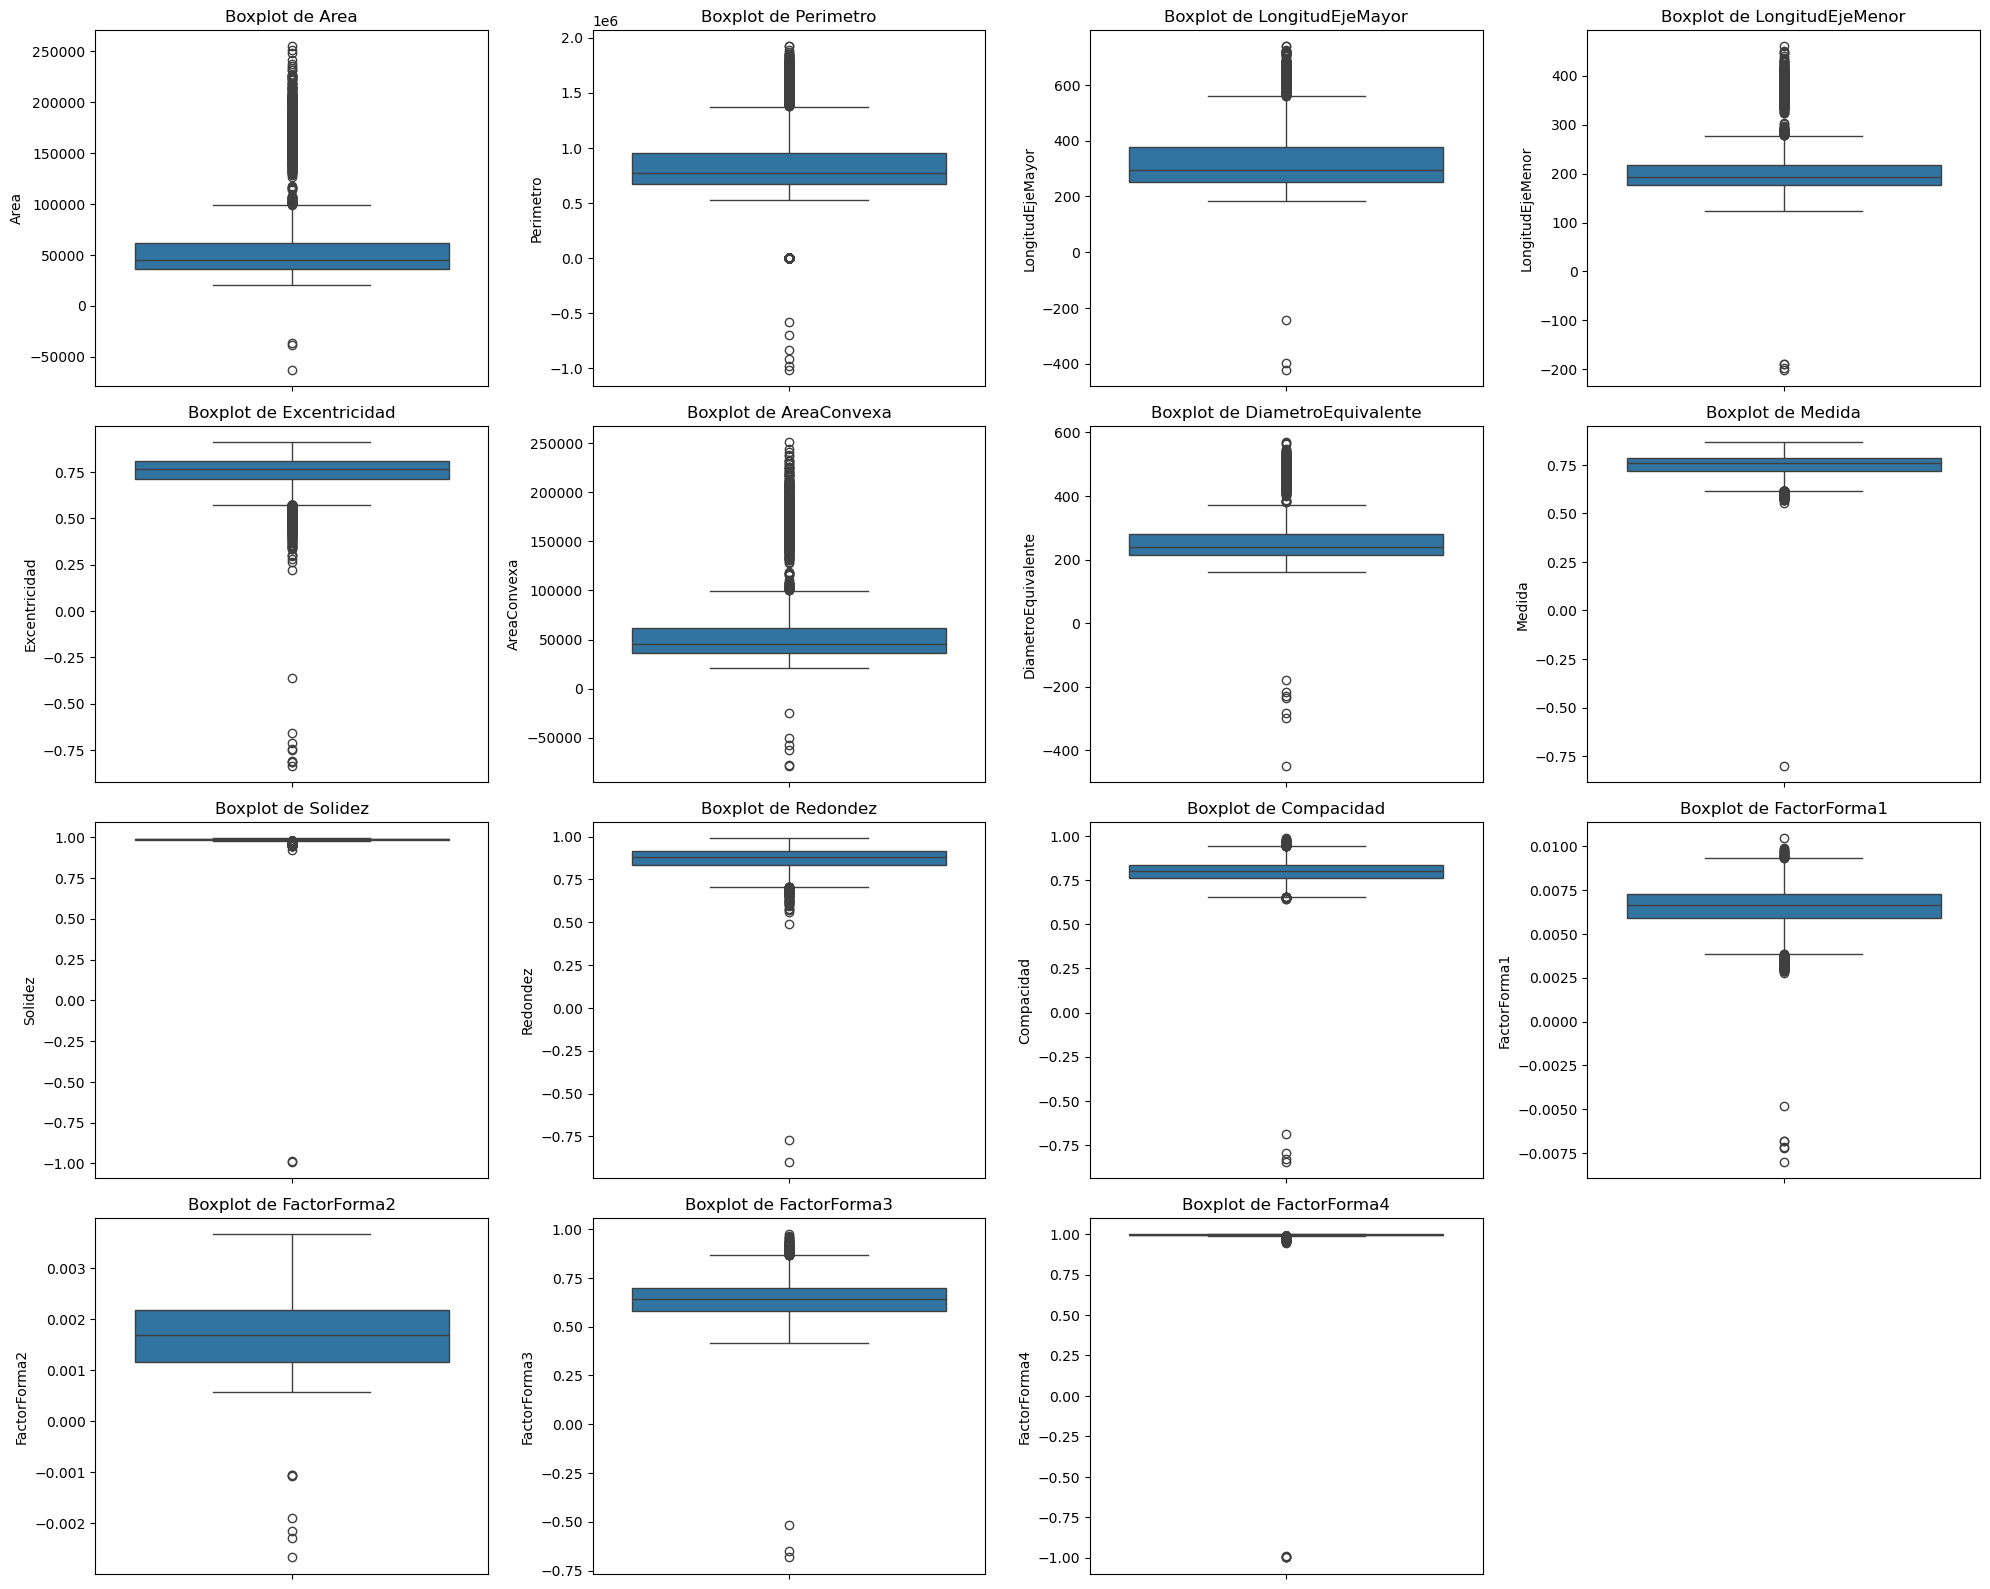

In [58]:
columnas_por_fila = 4
filas_boxplot = math.ceil(len(numericas) / columnas_por_fila)

fig, axes_box = plt.subplots(filas_boxplot, columnas_por_fila, figsize=(columnas_por_fila * 5, filas_boxplot * 4))
axes_box = axes_box.flatten()

for ax, col in zip(axes_box, numericas):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f"Boxplot de {col}")
    ax.set_ylabel(col)

for ax in axes_box[len(numericas):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### 2.1.4 Conclusiones iniciales sobre las variables numéricas

Del análisis de las gráficas de dispersión, histogramas y boxplots se destacan las siguientes observaciones:

1. Escalas muy diferentes entre variables:  
   Algunas variables como Área, Perímetro, LongitudEjeMayor y ÁreaConvexa alcanzan valores en el orden de cientos de miles, mientras que otras como Solidez, Redondez, Compacidad, Medida y los Factores de forma están acotadas entre 0 y 1. Esto confirma la necesidad de aplicar escalado o normalización antes de entrenar los algoritmos de agrupación.

2. Distribuciones asimétricas y sesgos:  
   Varias variables presentan distribuciones sesgadas hacia la derecha, por ejemplo Área, Perímetro y DiametroEquivalente. En el caso de las variables acotadas, como Solidez y Redondez, la mayoría de valores se concentran en el extremo superior. Estos patrones de distribución podrían requerir transformaciones (como logaritmos) para estabilizar la varianza.

3. Valores atípicos (outliers):  
   Los boxplots muestran una gran cantidad de valores extremos en casi todas las variables. Incluso se observan registros negativos en variables que conceptualmente deberían ser positivas, como Área, Perímetro y DiametroEquivalente. Estos casos deben ser evaluados para decidir si se eliminan, se imputan o se mantienen.

4. Variables con poca variabilidad:  
   Algunas variables como Solidez y FactorForma4 están muy concentradas en valores cercanos a 1, lo que limita su poder discriminante para diferenciar grupos. Es posible que tengan poca relevancia para el clustering.

5. Implicaciones para el modelado: 
   - Algoritmos como K-Means y Gaussian Mixture son sensibles a las diferencias de escala y a los outliers, por lo que se debe asegurar un preprocesamiento cuidadoso.  
   - Algoritmos más robustos como DBSCAN o Agglomerative Clustering podrían ser útiles para manejar distribuciones irregulares y valores extremos.  
   - Será necesario complementar este análisis con una matriz de correlación para evitar redundancia de variables antes de modelar.

En conclusión, los datos presentan heterogeneidad en escalas, distribuciones sesgadas y valores atípicos que deberán ser tratados en la etapa de preparación, con el fin de garantizar resultados consistentes en los algoritmos de agrupación.


## 2.2 Análisis del perfilamiento

En esta sección se revisa la calidad del conjunto de datos desde varios ángulos: filas duplicadas, valores nulos, estadísticas descriptivas, correlaciones entre variables numéricas y verificación de rangos plausibles según el diccionario. Este perfilamiento permite detectar problemas antes de la preparación y el modelado.


### 2.2.1 Análisis de filas duplicadas


En esta celda se identifican registros duplicados de dos formas. Primero, se buscan filas idénticas en todas las columnas. Segundo, se verifica si existen códigos ID repetidos, asumiendo que el identificador debe ser único por grano. Si se encuentran duplicados, se listan ejemplos para su inspección.


In [59]:
duplicadas_df = df[df.duplicated(keep=False)]
n_duplicadas = df.duplicated().sum()

print("Cantidad de filas duplicadas:", n_duplicadas)
display(duplicadas_df.head(5))

if "ID" in df.columns:
    dup_por_id = df[df["ID"].duplicated(keep=False)].sort_values("ID")
    n_ids_dup = df["ID"].duplicated().sum()
    print("\nCantidad de IDs repetidos:", n_ids_dup)
    display(dup_por_id.head(5))


Cantidad de filas duplicadas: 461


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
16,G000100,33143,NaN,222.526309,189.737379,Redondeado,0.522480,33377.0,205.423899,0.769980,0.992989,0.990685,0.923144,0.006714,NaN,0.852195,NaN,Normal,NaN
20,G012961,36876,707667.0,261.019476,180.562424,Alargado,0.722129,37270.0,216.684059,0.716136,0.989428,0.925328,0.830145,0.007078,0.002074,0.689141,0.996216,Normal,Natural
30,G009056,45954,795062.0,294.820672,199.020609,Alargado,0.737766,46398.0,241.889334,0.780296,0.990431,0.913548,0.820463,0.006416,0.001793,0.673159,0.997189,Normal,Lavado
37,G000534,36568,691529.0,241.392193,193.119305,Redondeado,0.599969,36883.0,215.777255,0.789669,0.991459,0.960927,0.893887,0.006601,0.002600,0.799033,0.998763,Normal,Lavado
40,G011077,29081,636593.0,237.301527,156.431380,Alargado,0.751959,29481.0,192.424217,0.703680,0.986432,0.901769,0.810885,0.008160,0.002176,0.657534,0.997459,Normal,Natural



Cantidad de IDs repetidos: 680


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
7772,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
824,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
13306,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
1246,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
11738,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado


Se encontraron 461 filas duplicadas en el dataset. Además, también se detectaron identificadores (ID) repetidos, lo que confirma que no todos los registros representan granos únicos. 
Para la preparación será necesario decidir si se eliminan estos duplicados para evitar sesgos en el análisis de agrupación, ya que podrían inflar artificialmente ciertos clusters.

### 2.2.2 Valores nulos


En esta celda se cuantifica la presencia de valores nulos por columna y se visualiza su porcentaje. Esta información ayuda a decidir estrategias de imputación o eliminación en la fase de preparación, considerando el impacto de cada variable en el análisis.


,n_nulos,%_nulos
DefectoVisible,2935,20.54
Solidez,2306,16.14
Redondez,2063,14.44
DiametroEquivalente,1923,13.46
AreaConvexa,1423,9.96
Perimetro,1237,8.66
FactorForma4,1159,8.11
FactorForma1,1119,7.83
FactorForma2,1106,7.74
Compacidad,650,4.55


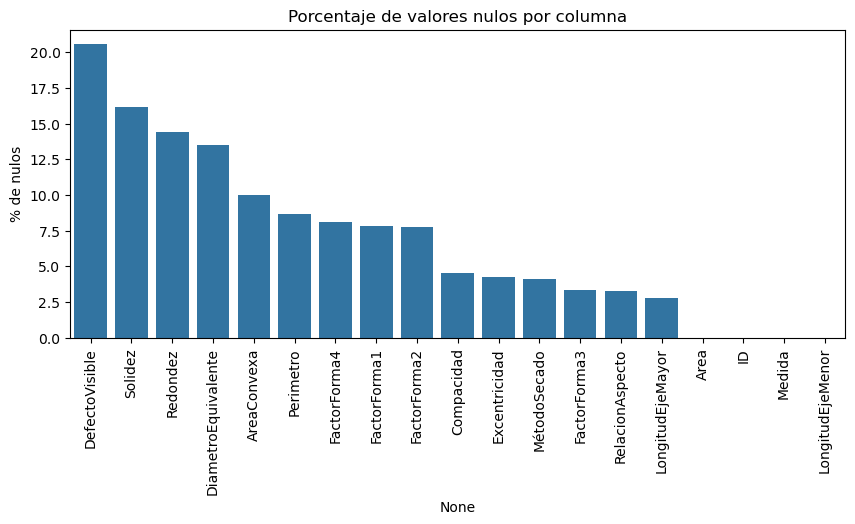

In [60]:
# Conteo y porcentaje de nulos por columna
nul_count = df.isna().sum().sort_values(ascending=False)
nul_pct = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
nulos = pd.concat([nul_count, nul_pct], axis=1)
nulos.columns = ["n_nulos", "%_nulos"]
display(nulos)

# Visualización rápida de nulos por columna
plt.figure(figsize=(10, 4))
sns.barplot(x=nulos.index, y=nulos["%_nulos"])
plt.xticks(rotation=90)
plt.ylabel("% de nulos")
plt.title("Porcentaje de valores nulos por columna")
plt.show()


En cuanto a los valores nulos, se observó que varias variables presentan porcentajes considerables de ausencia de información. DefectoVisible es la más afectada con alrededor del 20 por ciento de registros sin valor, mientras que Solidez, Redondez y DiametroEquivalente superan el 13 por ciento. Otras variables geométricas como Área, LongitudEjeMayor y LongitudEjeMenor casi no presentan datos faltantes. Esta situación implica que deben adoptarse distintas estrategias de tratamiento: en variables categóricas como DefectoVisible puede ser útil asignar la categoría “Desconocido”, y en las variables numéricas con porcentajes intermedios de nulos conviene emplear técnicas de imputación como la media, la mediana o métodos más robustos. Por su parte, las variables sin datos faltantes no requieren ajustes adicionales.

### 2.2.3 Estadísticas descriptivas de variables numéricas


En esta celda se resumen medidas descriptivas por variable numérica, incluyendo percentiles, medias y dispersiones. También se reportan el sesgo y la curtosis para evaluar asimetrías y colas pesadas, lo que orienta decisiones sobre transformaciones y escalado.


In [61]:
desc = df[numericas].describe().T
display(desc)

extra = pd.DataFrame({
    "skew": df[numericas].skew(numeric_only=True),
    "kurtosis": df[numericas].kurt(numeric_only=True)
}).round(3)
display(extra)


,count,mean,std,min,25%,50%,75%,max
Area,14291.0,53055.408999,29396.080372,-6.271600e+04,36338.000000,44660.000000,61311.000000,2.546160e+05
Perimetro,13054.0,772986.954791,326649.281155,-1.012143e+06,676860.750000,772034.500000,955409.750000,1.921685e+06
LongitudEjeMayor,13890.0,319.985592,86.378452,-4.214447e+02,253.319858,296.682345,376.548109,7.388602e+02
LongitudEjeMenor,14291.0,202.178613,45.494541,-2.008387e+02,175.881052,192.437870,216.847844,4.601985e+02
Excentricidad,13687.0,0.749977,0.099438,-8.350038e-01,0.715144,0.764392,0.810441,9.114230e-01
AreaConvexa,12868.0,53575.397809,29566.387814,-7.842300e+04,36720.000000,45107.500000,62109.250000,2.510820e+05
DiametroEquivalente,12368.0,253.001741,60.542330,-4.484026e+02,215.302463,238.579492,279.672481,5.693744e+02
Medida,14291.0,0.749844,0.050774,-7.987057e-01,0.718767,0.760232,0.786942,8.661946e-01
Solidez,11985.0,0.986774,0.025947,-9.890416e-01,0.985597,0.988279,0.989991,9.943782e-01
Redondez,12228.0,0.873080,0.063237,-8.968612e-01,0.832824,0.883353,0.916803,9.906854e-01


,skew,kurtosis
Area,2.933,10.732
Perimetro,-0.574,2.011
LongitudEjeMayor,1.232,3.272
LongitudEjeMenor,1.989,7.869
Excentricidad,-3.001,33.344
AreaConvexa,2.893,10.778
DiametroEquivalente,1.450,8.252
Medida,-2.797,60.768
Solidez,-73.625,5601.860
Redondez,-3.753,87.443


Las estadísticas muestran que algunas variables como Área, Perímetro, LongitudEjeMayor y ÁreaConvexa tienen valores negativos, lo cual no es consistente con su definición geométrica y sugiere la existencia de errores de registro o problemas en la extracción de características. Además, varias variables presentan rangos muy amplios y desviaciones estándar elevadas, lo que confirma la heterogeneidad en las escalas del dataset. Variables como Solidez y FactorForma4 se concentran en valores muy altos cercanos a 1, lo que implica baja variabilidad y poca capacidad discriminante entre observaciones.

El análisis de sesgo y curtosis indica que muchas variables tienen distribuciones fuertemente asimétricas y con colas pesadas. Por ejemplo, Área y ÁreaConvexa presentan un sesgo positivo con curtosis elevada, lo que refleja la presencia de colas largas hacia valores altos. En contraste, variables como Solidez y FactorForma4 muestran sesgos y curtosis extremadamente altos debido a su concentración en un rango muy reducido. Estas características sugieren la necesidad de transformaciones y del uso de escaladores robustos para que los algoritmos de agrupación no se vean dominados por valores extremos.

### 2.2.4 Correlación entre variables numéricas


En esta celda se calcula y se grafica la matriz de correlación de Pearson para las variables numéricas. Luego se listan los pares de variables con mayor correlación absoluta. Esta revisión permite identificar redundancias que podrían simplificarse antes del modelado o tenerse en cuenta al interpretar los clusters.


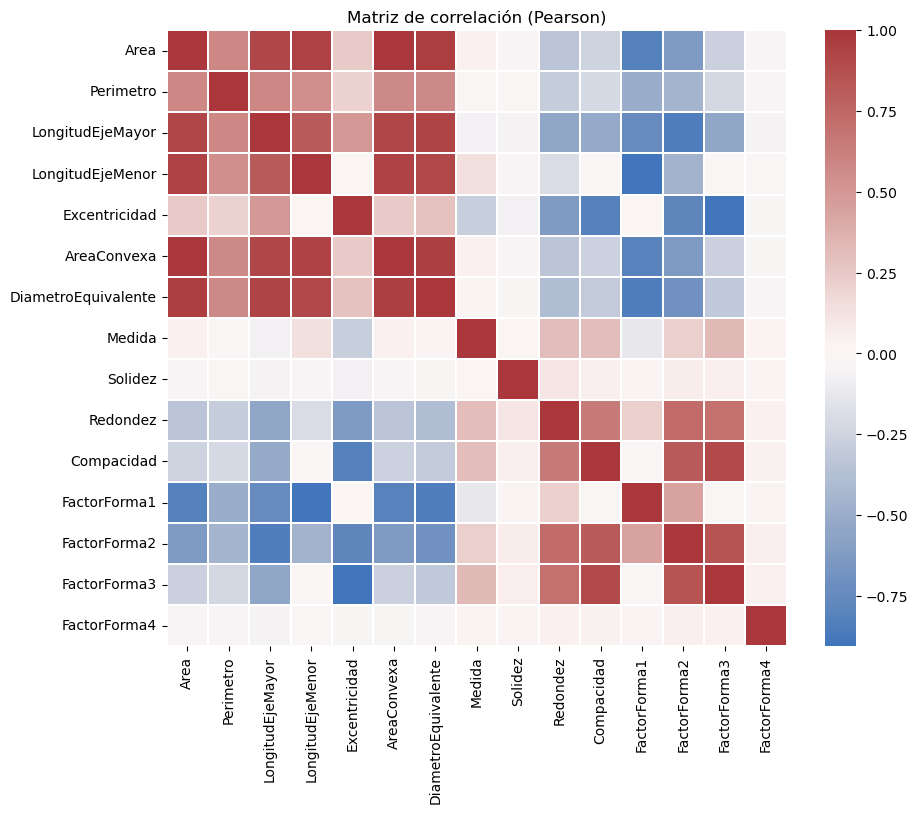

,var_1,var_2,corr_abs
0,Area,AreaConvexa,0.994689
1,Area,DiametroEquivalente,0.958933
2,AreaConvexa,DiametroEquivalente,0.952511
3,Area,LongitudEjeMenor,0.940869
4,LongitudEjeMenor,AreaConvexa,0.935487
5,LongitudEjeMayor,DiametroEquivalente,0.931813
6,Area,LongitudEjeMayor,0.924025
7,LongitudEjeMayor,AreaConvexa,0.920834
8,LongitudEjeMenor,DiametroEquivalente,0.913890
9,LongitudEjeMenor,FactorForma1,0.905972


In [62]:
corr = df[numericas].corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="vlag", center=0, linewidths=.25)
plt.title("Matriz de correlación (Pearson)")
plt.show()

corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .head(15)
         .rename("corr_abs")
         .reset_index()
         .rename(columns={"level_0": "var_1", "level_1": "var_2"})
)
display(top_pairs)


## 2.3 Análisis de calidad

En esta sección se evalúa la calidad de los datos considerando cuatro dimensiones principales:

- Completitud: se revisa el grado en que las variables presentan valores faltantes o ausentes.  
- Unicidad: se analiza la existencia de registros o identificadores duplicados que puedan afectar la confiabilidad del dataset.  
- Consistencia: se identifican posibles discrepancias en los valores que indiquen errores de captura o cálculo.  
- Validez: se comprueba que los valores respeten los formatos y rangos esperados de acuerdo con la definición de cada variable.  

El análisis de calidad permite determinar qué tan confiables y útiles son los datos para el proceso de agrupación.


### 2.3.1 Completitud


El análisis de completitud muestra la cantidad y el porcentaje de valores nulos por columna. En este dataset se observa que variables como DefectoVisible y Solidez presentan porcentajes elevados de valores ausentes, mientras que otras como Área o LongitudEjeMayor prácticamente no tienen faltantes. Esto sugiere que será necesario aplicar estrategias de imputación diferenciadas según la naturaleza de cada variable.


In [63]:
# Conteo y porcentaje de valores nulos por columna
faltantes = df.isnull().sum()
porcentaje_faltante = 100 * df.isnull().sum() / len(df)

completitud = pd.DataFrame({
    "Valores_faltantes": faltantes,
    "Porcentaje": porcentaje_faltante.round(2)
}).sort_values(by="Porcentaje", ascending=False)

display(completitud)


,Valores_faltantes,Porcentaje
DefectoVisible,2935,20.54
Solidez,2306,16.14
Redondez,2063,14.44
DiametroEquivalente,1923,13.46
AreaConvexa,1423,9.96
Perimetro,1237,8.66
FactorForma4,1159,8.11
FactorForma1,1119,7.83
FactorForma2,1106,7.74
Compacidad,650,4.55


### 2.3.2 Unicidad


El análisis de unicidad confirma que existen registros con identificadores repetidos. Esto significa que no todos los granos tienen un código único en el dataset. Para evitar sesgos en los resultados de agrupación será necesario eliminar los duplicados o decidir una forma de consolidarlos en la etapa de preparación.


In [64]:
ids_duplicados = df["ID"].duplicated().sum()
print("Cantidad de IDs duplicados:", ids_duplicados)


Cantidad de IDs duplicados: 680


In [65]:
import re

id_col = None
for c in df.columns:
    if re.fullmatch(r"\s*id\s*", str(c), flags=re.IGNORECASE):
        id_col = c
        break

if id_col is not None and id_col != "ID":
    df = df.rename(columns={id_col: "ID"})
    id_col = "ID"

if id_col is None:
    print("No se encontró una columna equivalente a 'ID'. Revisa los encabezados impresos en la celda anterior.")
else:
    ids_duplicados = df[id_col].duplicated().sum()
    print("Cantidad de IDs duplicados:", ids_duplicados)

    dup_rows = df[df[id_col].duplicated(keep=False)].sort_values(id_col).head(10)
    display(dup_rows)


Cantidad de IDs duplicados: 680


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
7772,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
824,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
13306,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
1246,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
11738,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado
983,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado
8611,G000064,32525,663914.0,225.077856,184.214734,Redondeado,0.574579,33000.0,203.499671,0.769058,NaN,0.927264,0.904130,0.006920,0.002852,0.817451,0.998781,Normal,Lavado
779,G000064,32525,663914.0,225.077856,184.214734,Redondeado,0.574579,33000.0,203.499671,0.769058,NaN,0.927264,0.904130,0.006920,0.002852,0.817451,0.998781,Normal,Lavado
10441,G000071,32713,660043.0,215.416321,193.486462,Redondeado,0.439592,33020.0,204.086955,0.799516,0.990703,0.943595,0.947407,0.006585,0.003273,0.897580,0.999312,Normal,Lavado
1125,G000071,32713,660043.0,215.416321,193.486462,Redondeado,0.439592,33020.0,204.086955,0.799516,0.990703,0.943595,0.947407,0.006585,0.003273,0.897580,0.999312,Normal,Lavado


### 2.3.3 Consistencia


En el análisis de consistencia se detectan valores que no cumplen con los rangos esperados según la definición de las variables. Por ejemplo, algunas medidas geométricas presentan valores negativos que no tienen sentido en este contexto, y ciertas proporciones exceden el rango entre 0 y 1. Estos casos deberán ser tratados en la preparación de datos para evitar distorsiones en los modelos de clustering.


In [66]:
# Variables que deberían estar en [0,1]
bounded = ["Excentricidad", "Solidez", "Redondez", "Compacidad", "Medida", "FactorForma4"]

violaciones_bounded = {}
for col in bounded:
    if col in df.columns:
        mask = (df[col] < 0) | (df[col] > 1)
        violaciones_bounded[col] = int(mask.sum())

violaciones_bounded = pd.Series(violaciones_bounded, name="fuera_[0,1]")
display(violaciones_bounded)

# Variables que no deberían tener valores negativos
non_negative = ["Area", "Perimetro", "LongitudEjeMayor", "LongitudEjeMenor", "AreaConvexa", "DiametroEquivalente"]

violaciones_neg = {}
for col in non_negative:
    if col in df.columns:
        mask = df[col] < 0
        violaciones_neg[col] = int(mask.sum())

violaciones_neg = pd.Series(violaciones_neg, name="negativos")
display(violaciones_neg)


Excentricidad    9
Solidez          2
Redondez         2
Compacidad       4
Medida           1
FactorForma4     5
Name: fuera_[0,1], dtype: int64

Area                   3
Perimetro              6
LongitudEjeMayor       3
LongitudEjeMenor       4
AreaConvexa            6
DiametroEquivalente    7
Name: negativos, dtype: int64

### 2.3.4 Validez


En el análisis de validez se revisan las variables categóricas para comprobar que los valores registrados correspondan con las categorías esperadas. Por ejemplo, RelacionAspecto debería contener etiquetas como Alargado o Redondeado, mientras que MétodoSecado incluye Lavado y Natural. Si se encuentran valores no esperados o inconsistentes, estos deberán ser corregidos o recategorizados.


In [67]:
for col in ["RelacionAspecto", "DefectoVisible", "MétodoSecado"]:
    if col in df.columns:
        print(f"\nColumna: {col}")
        print("Valores únicos:", df[col].dropna().unique())



Columna: RelacionAspecto
Valores únicos: ['alargado' 'Alargado' 'Redondeado' 'redondeado']

Columna: DefectoVisible
Valores únicos: ['Normal' 'normal']

Columna: MétodoSecado
Valores únicos: ['Lavado' 'Natural' 'lavado' 'natural' 'Honey' 'honey']


## 3. Preparación de los Datos

En esta etapa se busca limpiar y transformar el dataset para asegurar que la información sea confiable y esté lista para el modelado. Las principales acciones son:

- Verificar y eliminar valores nulos, en caso de existir.
- Identificar y tratar valores atípicos u outliers en variables numéricas revisadas en los diagramas de dispersión e histogramas

En esta celda se eliminan primero las filas idénticas en todas las columnas y luego los registros con identificadores repetidos, conservando la primera aparición. Esto asegura que cada grano tenga una única representación en el conjunto de datos.


### 3.1 Eliminación de duplicados


En esta celda se eliminan primero las filas idénticas en todas las columnas y luego los registros con identificadores repetidos, conservando la primera aparición. Esto asegura que cada grano tenga una única representación en el conjunto de datos.


In [68]:
# Eliminar filas duplicadas completas
print("Tamaño original:", df.shape)
df_prep = df.drop_duplicates()
print("Después de eliminar duplicados:", df_prep.shape)

# Verificar duplicados por ID
if "ID" in df_prep.columns:
    df_prep = df_prep.drop_duplicates(subset=["ID"], keep="first")
    print("Después de eliminar IDs duplicados:", df_prep.shape)


Tamaño original: (14291, 19)
Después de eliminar duplicados: (13830, 19)
Después de eliminar IDs duplicados: (13611, 19)


### 3.2 Eliminación de registros inconsistentes


En esta celda se eliminan los registros que no cumplen con los rangos definidos o que contradicen reglas geométricas básicas. Se descartan valores negativos en variables que deben ser no negativas, proporciones fuera del intervalo [0,1] y casos donde el Área supera el ÁreaConvexa o la LongitudEjeMenor es mayor a la LongitudEjeMayor.


In [69]:
mask_invalido = pd.Series(False, index=df_prep.index)

for col in ["Excentricidad", "Solidez", "Redondez", "Compacidad", "Medida", "FactorForma4"]:
    if col in df_prep.columns:
        mask_invalido |= (df_prep[col] < 0) | (df_prep[col] > 1)

for col in ["Area", "Perimetro", "LongitudEjeMayor", "LongitudEjeMenor", "AreaConvexa", "DiametroEquivalente",
            "FactorForma1", "FactorForma2", "FactorForma3"]:
    if col in df_prep.columns:
        mask_invalido |= (df_prep[col] < 0)

if {"Area", "AreaConvexa"}.issubset(df_prep.columns):
    mask_invalido |= df_prep["Area"] > df_prep["AreaConvexa"]

if {"LongitudEjeMenor", "LongitudEjeMayor"}.issubset(df_prep.columns):
    mask_invalido |= df_prep["LongitudEjeMenor"] > df_prep["LongitudEjeMayor"]

print("Registros originales:", df.shape[0])
print("Registros luego de eliminar inconsistentes:", df_prep[~mask_invalido].shape[0])

df_prep = df_prep[~mask_invalido]


Registros originales: 14291
Registros luego de eliminar inconsistentes: 13548


### 3.3 Imputación de valores nulos

En esta sección se imputan los valores faltantes para conservar la mayor cantidad posible de observaciones.  
- Para variables numéricas se utilizará la mediana, que es robusta frente a valores atípicos.  
- Para variables categóricas se asignará la categoría "Desconocido".  


In [70]:
from sklearn.impute import SimpleImputer


df_imp = df_prep.copy()

num_cols = df_imp.select_dtypes(include=["float64", "int64"]).columns
cat_cols = [c for c in ["RelacionAspecto", "DefectoVisible", "MétodoSecado"] if c in df_imp.columns]


imputer_num = SimpleImputer(strategy="median")
df_imp[num_cols] = imputer_num.fit_transform(df_imp[num_cols])


for col in cat_cols:
    df_imp[col] = df_imp[col].fillna("Desconocido")

print("Tamaño del dataset después de imputación:", df_imp.shape)
print("\nValores nulos restantes:")
print(df_imp.isna().sum().sort_values(ascending=False).head(10))


Tamaño del dataset después de imputación: (13548, 19)

Valores nulos restantes:
ID                     0
Area                   0
Perimetro              0
LongitudEjeMayor       0
LongitudEjeMenor       0
RelacionAspecto        0
Excentricidad          0
AreaConvexa            0
DiametroEquivalente    0
Medida                 0
dtype: int64


Con esta imputación se logró conservar los registros que antes se hubieran eliminado al aplicar dropna.  
- Las variables numéricas fueron completadas con la mediana de cada columna, evitando distorsión por outliers.  
- Las variables categóricas recibieron la categoría "Desconocido" para no perder información y permitir que en la validación cualitativa se interprete este grupo aparte.  
El resultado es un conjunto de datos sin valores faltantes, listo para el escalado y el modelado.


### 3.4 Eliminacion de outliers

En este paso se realiza la detección y eliminación de outliers extremos en las variables de tamaño, ya que estos valores atípicos distorsionan los centroides y la formación de clusters en el modelo KMeans. Para esto se aplica el método del rango intercuartílico (IQR), eliminando los registros que estén por debajo de Q1 - 1.5IQR o por encima de Q3 + 1.5IQR en las variables Área, Perímetro y Diámetro Equivalente. De esta forma se reduce el impacto de granos anómalos o errores de captura en el agrupamiento final

In [71]:
# Definir variables clave para detección de outliers
vars_outliers = ["Area", "Perimetro", "DiametroEquivalente"]

df_clean = df_imp.copy()  # trabajar sobre el dataset imputado

# Detección y eliminación de outliers con IQR
for col in vars_outliers:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    before = df_clean.shape[0]
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    after = df_clean.shape[0]
    
    print(f"Variable {col}: eliminados {before - after} outliers")

print(f"\nTamaño final del dataset después de limpieza de outliers: {df_clean.shape}")


Variable Area: eliminados 549 outliers
Variable Perimetro: eliminados 1157 outliers
Variable DiametroEquivalente: eliminados 191 outliers

Tamaño final del dataset después de limpieza de outliers: (11651, 19)


In [72]:
# Recorte por percentiles en variables de tamaño (ajusta si lo necesitas)
size_cols = ["Area", "Perimetro", "DiametroEquivalente"]
size_cols = [c for c in size_cols if c in df_clean.columns]

p_low, p_high = 0.01, 0.99   # 1% y 99%
prev = df_clean.shape[0]

for col in size_cols:
    lo, hi = df_clean[col].quantile([p_low, p_high]).tolist()
    mask_keep = (df_clean[col] >= lo) & (df_clean[col] <= hi)
    removed = (~mask_keep).sum()
    df_clean = df_clean[mask_keep]
    print(f"{col}: recorte [{p_low:.0%},{p_high:.0%}] → {removed} outliers eliminados")

print("Tamaño después de recorte por percentiles:", df_clean.shape)



Area: recorte [1%,99%] → 234 outliers eliminados
Perimetro: recorte [1%,99%] → 230 outliers eliminados
DiametroEquivalente: recorte [1%,99%] → 224 outliers eliminados
Tamaño después de recorte por percentiles: (10963, 19)


### 3.4 Selección de variables relevantes


In [73]:
vars_modelo = [
    'Area',
    'DiametroEquivalente',
    'Excentricidad',
    'Redondez',
    'Compacidad'
]

vars_modelo = [v for v in vars_modelo if v in df_clean.columns]

X = df_clean[vars_modelo].copy()
print("Variables seleccionadas:", vars_modelo)
print("Dimensiones de X:", X.shape)


Variables seleccionadas: ['Area', 'DiametroEquivalente', 'Excentricidad', 'Redondez', 'Compacidad']
Dimensiones de X: (10963, 5)


### Justificación de las variables seleccionadas para el modelo

Las variables escogidas corresponden a medidas geométricas y morfológicas extraídas de las imágenes de los granos de café. Estas son relevantes porque capturan la forma, el tamaño y la estructura de los granos, que son los atributos de mayor interés para SenecaféAlpes en su objetivo de caracterizar variedades y garantizar la uniformidad del producto.

- Área, Perímetro, LongitudEjeMayor, LongitudEjeMenor, ÁreaConvexa y DiámetroEquivalente representan el tamaño del grano y su extensión en diferentes dimensiones. Son esenciales para diferenciar granos grandes, pequeños o deformes.
- Excentricidad, Medida, Solidez, Redondez y Compacidad describen la forma y la proporción del grano. Estas medidas permiten identificar si los granos son más redondeados, alargados o presentan irregularidades.
- Los Factores de Forma 1 a 4 son índices derivados que integran relaciones entre medidas geométricas. Aportan información complementaria para capturar sutilezas en la estructura que no se aprecian solo con área o perímetro.

La decisión de excluir variables categóricas como RelacionAspecto, DefectoVisible y MétodoSecado se justifica porque los algoritmos de clustering utilizados se basan en distancias numéricas. Estas variables se conservarán únicamente para la interpretación cualitativa de los grupos una vez obtenidos los clusters.

En conclusión, las variables seleccionadas constituyen un conjunto robusto para el modelado porque combinan medidas de tamaño, proporción y forma, todas ellas directamente relacionadas con la calidad y la clasificación morfológica de los granos. Al ser estandarizadas y analizadas en conjunto, permiten descubrir patrones útiles para el control de calidad, la definición de mezclas y la trazabilidad del producto.


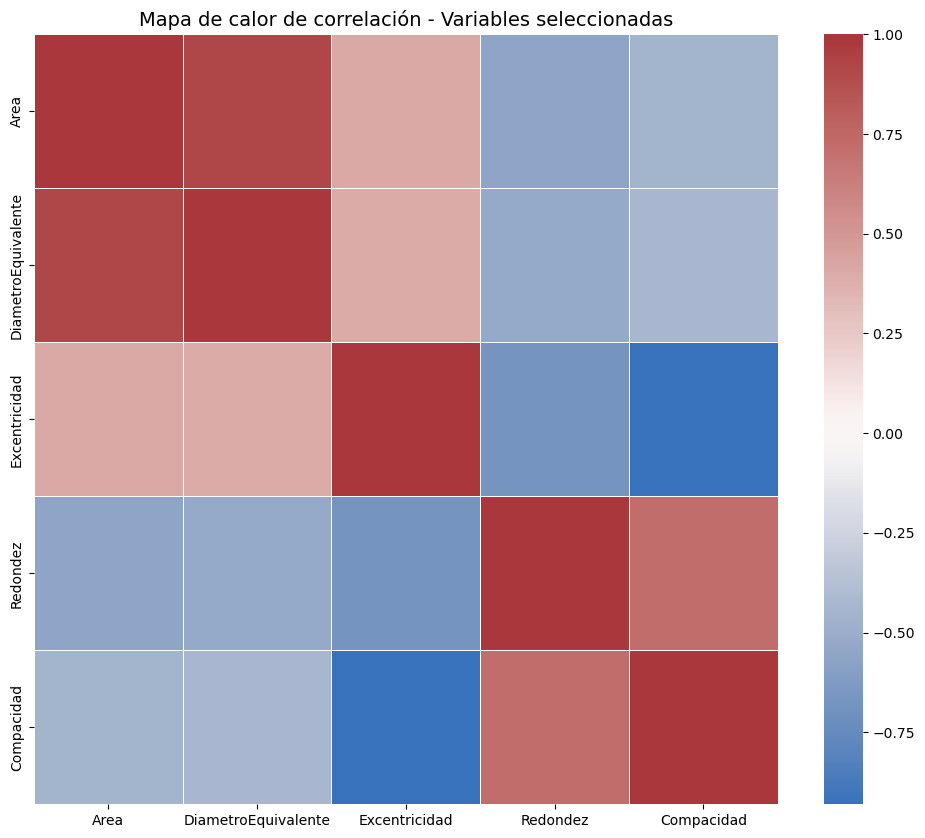

In [74]:
corr = X.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="vlag", center=0, annot=False, linewidths=.5)
plt.title("Mapa de calor de correlación - Variables seleccionadas", fontsize=14)
plt.show()


### 3.6 Exportación de los datos preparados

En esta celda se exporta el conjunto final de datos preparados, tanto completo como reducido a las variables seleccionadas para el clustering. De esta forma se conserva un respaldo que puede utilizarse en futuras etapas o reutilizarse sin necesidad de repetir todo el preprocesamiento.


In [75]:
df_clean.to_csv("SenecafeAlpes_preparado_completo.csv", index=False, encoding="utf-8-sig")
df_clean.to_excel("SenecafeAlpes_preparado_completo.xlsx", index=False)

X.to_csv("SenecafeAlpes_clustering_vars.csv", index=False, encoding="utf-8-sig")
X.to_excel("SenecafeAlpes_clustering_vars.xlsx", index=False)

print("Archivos exportados correctamente:")
print("- SenecafeAlpes_preparado_completo.csv / .xlsx")
print("- SenecafeAlpes_clustering_vars.csv / .xlsx")



Archivos exportados correctamente:
- SenecafeAlpes_preparado_completo.csv / .xlsx
- SenecafeAlpes_clustering_vars.csv / .xlsx


## 4. Entrenamiento de modelos

### 4.1 K-Means

El algoritmo K-Means es una técnica de clustering basada en la minimización de la distancia de cada punto al centroide más cercano. En este apartado se escalan previamente las variables seleccionadas para evitar que las diferencias de escala dominen el cálculo de distancias. Luego se entrenan modelos con distintos valores de K para determinar el número óptimo de clusters.


#### 4.1.1 Escalado de datos


En esta celda se aplicó el escalado estandarizado (media = 0, desviación estándar = 1) a todas las variables numéricas seleccionadas. Esto garantiza que todas las variables tengan el mismo peso en el cálculo de distancias, evitando que las de mayor rango (como Área o Perímetro) dominen el clustering.


In [76]:
from sklearn.preprocessing import StandardScaler

# Escalado de las variables seleccionadas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dimensiones de X_scaled:", X_scaled.shape)

Dimensiones de X_scaled: (10963, 5)


#### 4.1.2 Determinación del número óptimo de clusters


En esta celda se evaluaron diferentes valores de K entre 2 y 10 mediante el método del codo, graficando la inercia (suma de distancias cuadradas a los centroides). El punto de inflexión en la curva sugiere un número óptimo de clusters que logra un buen balance entre complejidad y calidad de agrupación.


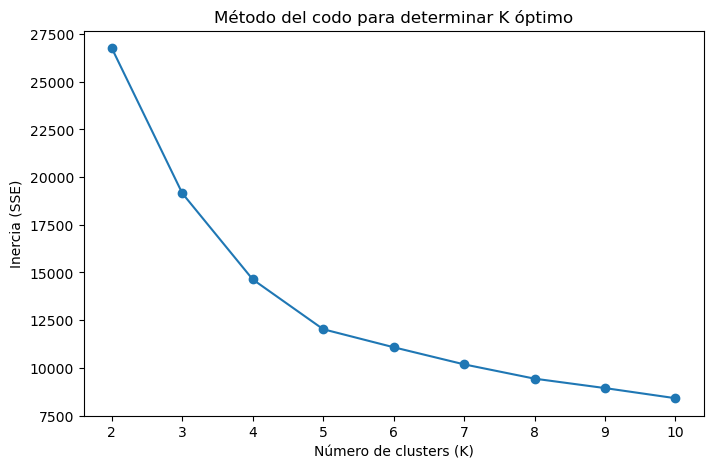

In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_values = range(2, 11)
inertia = []
sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker="o")
plt.title("Método del codo para determinar K óptimo")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (SSE)")
plt.show()


La curva es bastante suave y decreciente, sin un punto de inflexión muy marcado. Esto ocurre cuando los datos no tienen grupos claramente separados, sino que forman más bien una distribución continua. En ese caso, K-Means va reduciendo la inercia de forma gradual a medida que aumentas el número de clusters, pero sin un codo.
Para decidir con más criterio, lo ideal es complementar con otra métrica como el coeficiente de silueta o Davies–Bouldin index. Estas dan un valor cuantitativo de qué tan compactos y separados están los clusters para cada K.

#### 4.1.4 Evaluación de K con Silhouette y Davies–Bouldin

Para complementar el método del codo se utilizan dos métricas adicionales:

- Coeficiente de Silueta: valores más altos indican clusters más compactos y mejor separados.  
- Índice de Davies–Bouldin: valores más bajos indican mejor desempeño de clustering.  


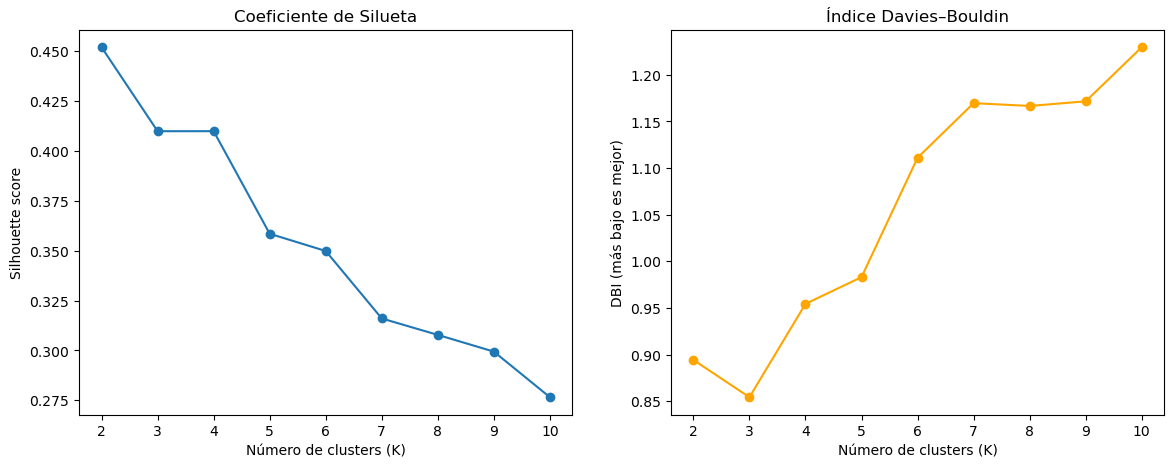

In [78]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_values = range(2, 11)
silhouette_scores = []
dbi_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Silhouette
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
    
    # DBI
    dbi = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(dbi)

# Graficar resultados
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].plot(k_values, silhouette_scores, marker="o")
axes[0].set_title("Coeficiente de Silueta")
axes[0].set_xlabel("Número de clusters (K)")
axes[0].set_ylabel("Silhouette score")

axes[1].plot(k_values, dbi_scores, marker="o", color="orange")
axes[1].set_title("Índice Davies–Bouldin")
axes[1].set_xlabel("Número de clusters (K)")
axes[1].set_ylabel("DBI (más bajo es mejor)")

plt.show()


En el coeficiente de silueta, el valor mas alto se da en K=3 y k=4. Despues cae de manera pronunciada. Y en el indice Davies-Bouldin, el minimo esta en k=3. Esto nos indica el k optimo es 3.

#### 4.1.5 Entrenamiento del modelo con K óptimo

Se entrena K-Means con el número de clusters seleccionado. Se obtienen las etiquetas para cada observación y se agregan al DataFrame preparado para su posterior análisis e interpretación.


In [79]:
from sklearn.cluster import KMeans

k_optimo = 3  # elegido según codo + silueta + DBI

kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_km = kmeans_final.fit_predict(X_scaled)

# Guardar etiquetas en el dataset preparado
df_clean["Cluster_KMeans"] = labels_km

print("Dimensiones de X_scaled:", X_scaled.shape)
print("Clusters aprendidos:", k_optimo)


Dimensiones de X_scaled: (10963, 5)
Clusters aprendidos: 3


In [80]:
import pandas as pd
import numpy as np

# Distribución de observaciones por cluster
conteo = df_clean["Cluster_KMeans"].value_counts().sort_index()
print("Distribución de observaciones por cluster:")
print(conteo)

# Centroides en escala original
centroides_orig = pd.DataFrame(
    scaler.inverse_transform(kmeans_final.cluster_centers_),
    columns=vars_modelo
)
centroides_orig.index = [f"Cluster_{i}" for i in range(k_optimo)]

print("\nCentroides en escala original:")
display(centroides_orig.round(4))


Distribución de observaciones por cluster:
Cluster_KMeans
0    5237
1    3876
2    1850
Name: count, dtype: int64

Centroides en escala original:


,Area,DiametroEquivalente,Excentricidad,Redondez,Compacidad
Cluster_0,38406.4142,222.8687,0.7529,0.8950,0.8085
Cluster_1,62325.6922,275.3385,0.8216,0.8229,0.7458
Cluster_2,38889.8521,223.9932,0.5838,0.9384,0.8959


En esta etapa se verificó el tamaño de cada grupo y se calcularon los centroides en la escala original de las variables. La distribución por cluster permite evaluar el balance de la partición y los centroides facilitan interpretar las características promedio de cada grupo en términos de tamaño y forma de los granos. Estos resultados se utilizarán en la siguiente sección para describir los clusters y validar su utilidad para el negocio.


#### 4.1.6 Visualización y análisis de los clusters

Se realizan distintas visualizaciones para comprender cómo se distribuyen los clusters en el espacio de variables, tanto mediante reducción de dimensionalidad (PCA) como con comparaciones bivariadas en variables de interés.


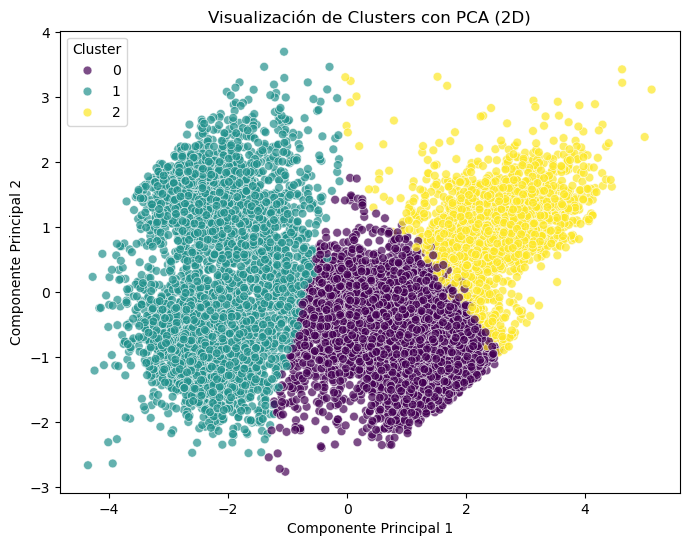

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir a 2 dimensiones con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_clean["Cluster_KMeans"], palette="viridis", s=40, alpha=0.7)
plt.title("Visualización de Clusters con PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()


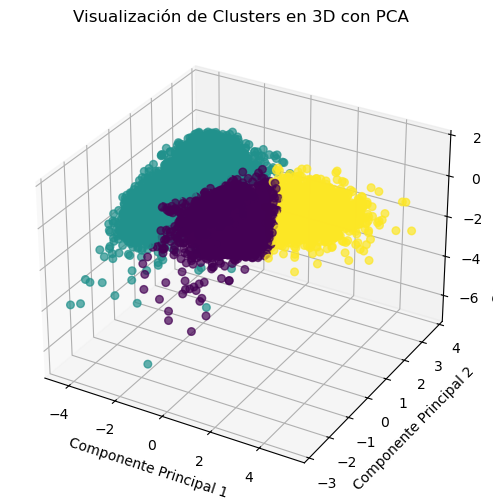

In [82]:
from mpl_toolkits.mplot3d import Axes3D

pca3d = PCA(n_components=3)
X_pca3 = pca3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
           c=df_clean["Cluster_KMeans"], cmap="viridis", s=30, alpha=0.7)

ax.set_title("Visualización de Clusters en 3D con PCA")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
plt.show()


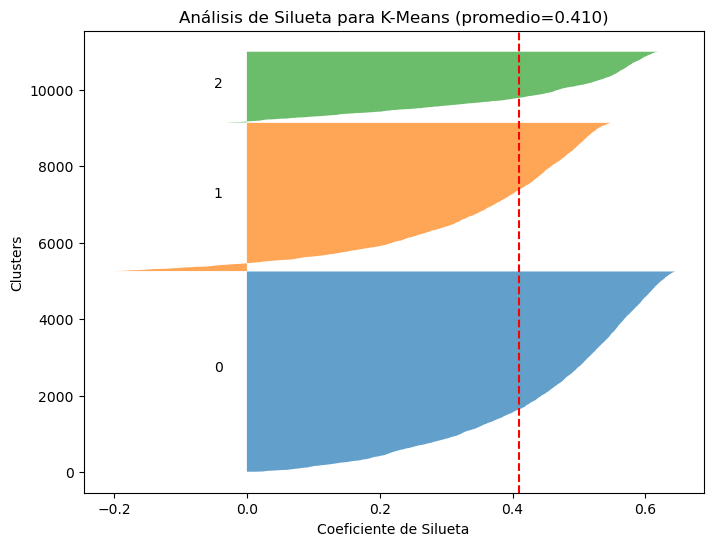

In [83]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

silhouette_vals = silhouette_samples(X_scaled, labels_km)
silhouette_avg = silhouette_score(X_scaled, labels_km)

plt.figure(figsize=(8,6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_silhouette_values = silhouette_vals[labels_km == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      alpha=0.7)
    plt.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title(f"Análisis de Silueta para K-Means (promedio={silhouette_avg:.3f})")
plt.xlabel("Coeficiente de Silueta")
plt.ylabel("Clusters")
plt.show()


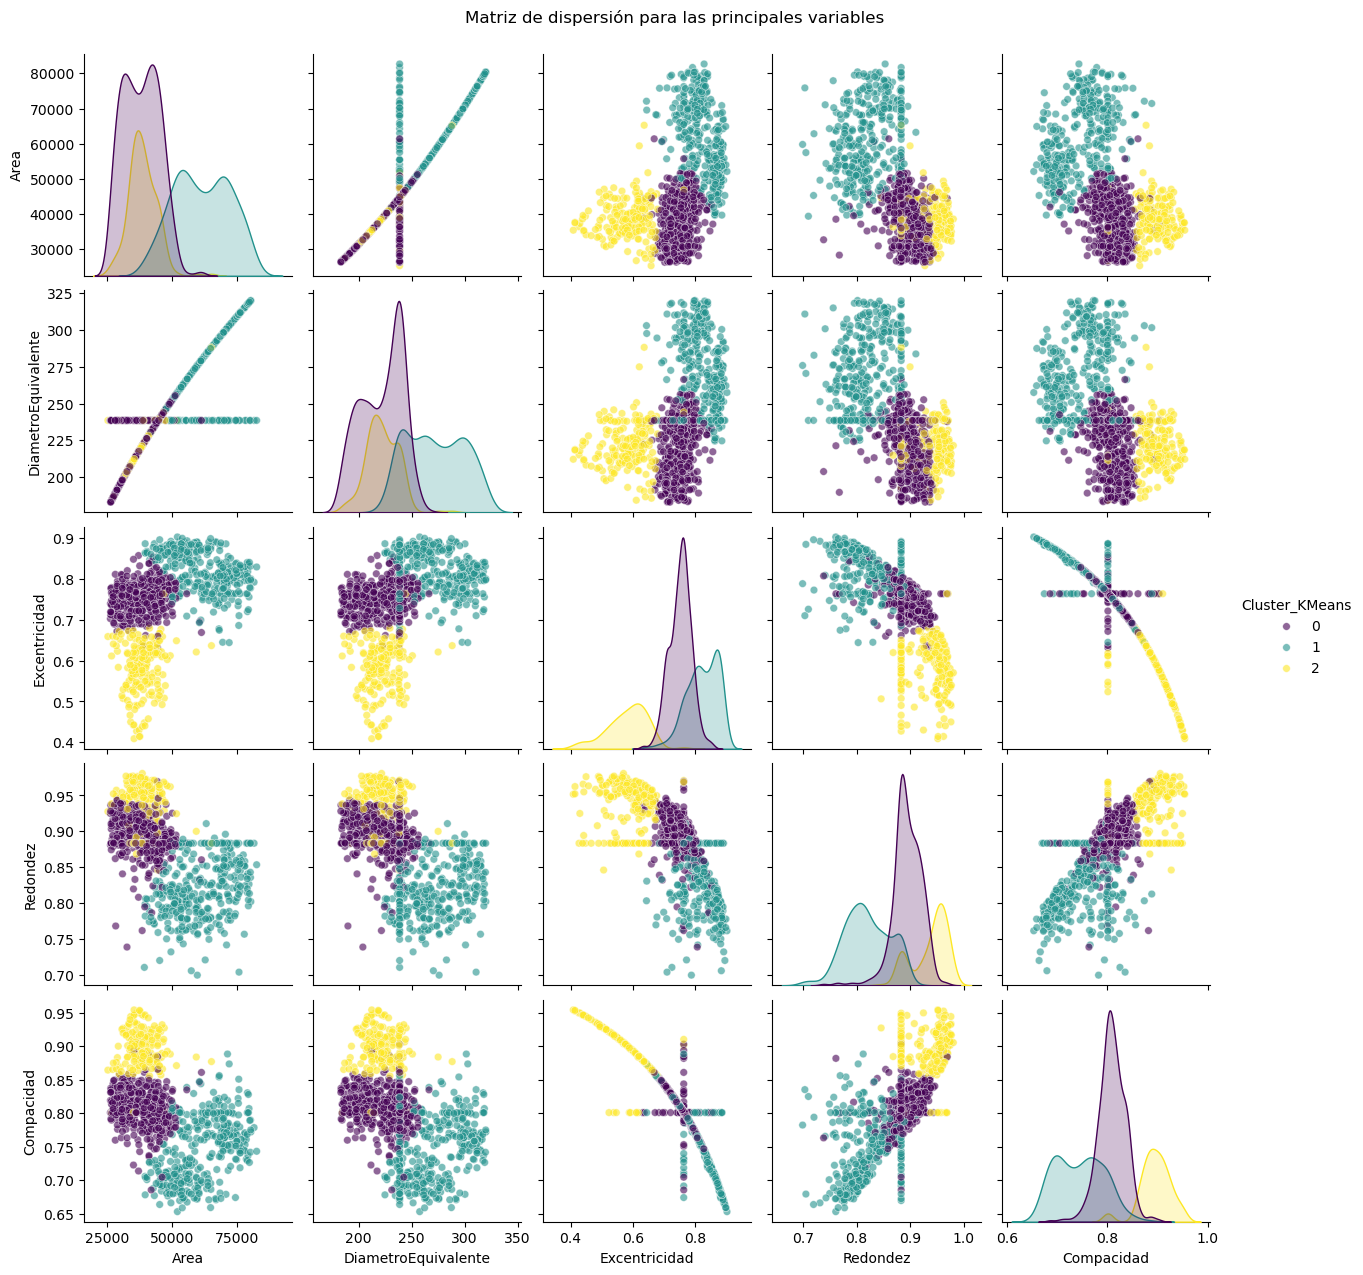

In [84]:
sns.pairplot(df_clean.sample(1000), vars=vars_modelo[:6], hue="Cluster_KMeans", palette="viridis", diag_kind="kde", plot_kws={"alpha":0.6, "s":30})
plt.suptitle("Matriz de dispersión para las principales variables", y=1.02)
plt.show()

En el proceso de clustering utilizando K-Means, se evaluaron diferentes valores de 
K mediante el coeficiente de silueta y el índice Davies-Bouldin. Ambos indicadores señalaron que el número óptimo de clusters se encuentra en 
K=3, ya que este punto logra un balance entre cohesión interna (menor dispersión dentro de cada grupo) y separación externa (mayor distancia entre clusters).

La visualización en dos dimensiones con PCA muestra una separación clara de los tres grupos, lo que evidencia que los clusters encontrados representan patrones diferenciados en los datos. Si bien existe cierta superposición entre puntos de frontera —lo cual es esperable en datos de alta dimensionalidad reducidos a dos componentes—, las agrupaciones principales resultan consistentes.

El análisis de las variables clave [Area, Diámetro Equivalente, Excentricidad, Redondez y Compacidad] respalda la validez de los clusters. Estas variables aportan una diferenciación notable: por ejemplo, un cluster está asociado a áreas y perímetros más grandes, mientras que otros se distinguen por una mayor compacidad o menor redondez. Las gráficas de dispersión y la matriz de pares confirman que cada cluster refleja un comportamiento distinto en estas dimensiones.

En conclusión, el modelo K-Means con K=3 logra capturar tres perfiles bien diferenciados en los datos, con una calidad de partición aceptable según las métricas empleadas. Esto sugiere que el preprocesamiento realizado permitió estabilizar el modelo y obtener clusters más interpretables.

### 4.2 DBSCAN

#### 4.2.1 Datos de entrada

En DBSCAN trabajamos directamente sobre distancias entre puntos, por eso vamos a reutilizar la matriz estandarizada que ya construimos en 4.1.1. Esto garantiza que ninguna variable domine el cálculo de vecinos solo por su escala

In [85]:
import numpy as np
import pandas as pd
# Empaquetar X_scaled en un DataFrame para trazabilidad
X_db = pd.DataFrame(X_scaled, columns=vars_modelo, index=df_clean.index)

print("Observaciones y variables en X_db:", X_db.shape)
display(X_db.head())

Observaciones y variables en X_db: (10963, 5)


,Area,DiametroEquivalente,Excentricidad,Redondez,Compacidad
0,0.279181,0.391459,0.167375,-2.330435,-1.458247
1,1.133550,1.254966,0.167375,-1.712268,-1.758126
2,0.933066,1.060276,1.196586,-2.086364,-1.449847
4,-0.545392,-0.544638,-0.674030,0.564562,0.817332
5,0.266145,0.377539,1.202783,-0.997079,-1.438011


la matriz de entrada X_db conserva las observaciones y variables seleccionadas, pero ahora en una escala estandarizada. los valores alrededor de cero y la mezcla de positivos y negativos reflejan que cada variable fue centrada y estandarizada. Con esto garantizamos que ninguna característica domine sobre las demás por su magnitud y dejamos los datos listos para aplicar DBSCAN

#### 4.2.2 Curva k-distance (heurística para eps)

Para aplicar DBSCAN necesitamos escoger dos hiperparámetros: el número mínimo de vecinos que definen un punto denso (min_samples) y la distancia máxima entre puntos para que sean considerados vecinos (eps). Una forma común de estimar un rango adecuado para eps es construir la curva k-distance.

Para ello, haremos lo siguiente:

- Calcular la distancia al k-ésimo vecino más cercano de cada observación, donde k corresponde a un valor tentativo de min_samples

- Ordenar esas distancias en forma ascendente

- Graficar la curva resultante y buscar el punto donde aparece un “codo”, ese valor suele ser una buena referencia para eps

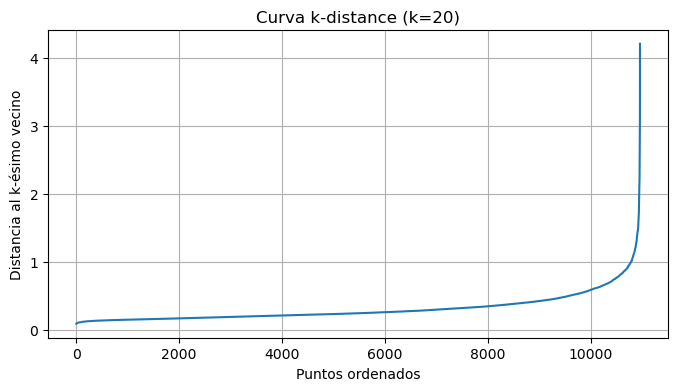

In [86]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

#  min_samples tentativo
k = 20  

# Calculamos distancias a los k vecinos
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_db)
distances, indices = nn.kneighbors(X_db)

# Seleccionamos la distancia al k-ésimo vecino
k_distances = np.sort(distances[:, -1])

# Graficamos
plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.title(f"Curva k-distance (k={k})")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al k-ésimo vecino")
plt.grid(True)
plt.show()


la curva k-distance muestra que la mayoría de los puntos tienen una distancia pequeña a su vecino número 20, pero hacia el final aparece un incremento brusco. El “codo” de la curva ocurre alrededor de valores entre 0.6 y 0.8 aproximadamente, lo que indica un rango razonable para eps. Este valor servirá como punto de partida para las pruebas de DBSCAN, combinado con distintos valores de min_samples.

#### 4.2.3 Búsqueda ligera de hiperparámetros

En esta parte hacemos una exploración inicial de hiperparámetros para DBSCAN. A partir de la curva k-distance tomamos varios valores posibles de eps y los combinamos con diferentes opciones de min_samples. El propósito es identificar configuraciones que produzcan grupos con cierta coherencia. Para evaluar la calidad de cada intento usamos dos métricas: la silueta, que mide qué tan separados y compactos están los grupos (valores más altos son mejores), y el índice de Davies–Bouldin, que compara la dispersión de cada cluster con respecto a su separación (valores más bajos son mejores). De esta manera tenemos una visión más completa del comportamiento del algoritmo y podemos elegir un punto de partida razonable para los siguientes pasos.

In [87]:
# Incluye Silhouette y Davies-Bouldin

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Asegurarnos de tener k_distances (de 4.2.2). Si no existe, lo calculamos rápido:
try:
    k_distances
except NameError:
    k = 20
    nn = NearestNeighbors(n_neighbors=k).fit(X_db)
    distances, _ = nn.kneighbors(X_db)
    k_distances = np.sort(distances[:, -1])

# 1) candidatos para eps basados en percentiles alrededor del "codo"
eps_grid = np.quantile(k_distances, [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
eps_grid = np.unique(np.round(eps_grid, 3)).tolist()

# 2) candidatos para min_samples
min_samples_grid = [10, 12, 15, 20]

results = []

for m in min_samples_grid:
    for eps in eps_grid:
        db = DBSCAN(eps=eps, min_samples=m, metric='euclidean')
        labels = db.fit_predict(X_db.values)

        # métricas básicas
        n_noise = np.sum(labels == -1)
        noise_ratio = n_noise / len(labels)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # inicializar métricas
        sil, dbi = np.nan, np.nan

        # solo calculamos si hay al menos 2 clusters y no es casi todo ruido
        if n_clusters >= 2 and noise_ratio < 0.95:
            try:
                sil = silhouette_score(X_db.values, labels, metric='euclidean')
                dbi = davies_bouldin_score(X_db.values, labels)
            except Exception:
                pass

        results.append({
            "min_samples": m,
            "eps": eps,
            "n_clusters": n_clusters,
            "noise_ratio": round(noise_ratio, 3),
            "silhouette": sil,
            "davies_bouldin": dbi
        })

results_df = pd.DataFrame(results).sort_values(
    by=["silhouette", "davies_bouldin"], ascending=[False, True]
).reset_index(drop=True)

display(pd.DataFrame({"eps_grid": eps_grid}, index=range(1, len(eps_grid)+1)))
print("Combinaciones evaluadas:", len(results_df))
display(results_df.head(12))

# Guardar mejor set de hiperparámetros preliminar
best_row = results_df.loc[results_df["silhouette"].notna()].head(1)
if not best_row.empty:
    best_eps = float(best_row["eps"].iloc[0])
    best_min_samples = int(best_row["min_samples"].iloc[0])
    print(f"Mejor combinación preliminar → eps={best_eps}, min_samples={best_min_samples}")
    
    db_best = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean')
    labels_best = db_best.fit_predict(X_db.values)

    # persistimos para las siguientes celdas
    df_dbscan = df_clean.copy()
    df_dbscan["cluster_dbscan"] = labels_best
else:
    print("No se encontraron combinaciones válidas con silueta. Revisar rango de eps/min_samples.")

,eps_grid
1,0.280
2,0.303
3,0.329
4,0.362
5,0.403
6,0.459
7,0.552
8,0.718


Combinaciones evaluadas: 32


,min_samples,eps,n_clusters,noise_ratio,silhouette,davies_bouldin
0,20,0.303,4,0.226,0.123780,1.721150
1,20,0.718,2,0.016,0.053031,2.390934
2,10,0.552,2,0.024,0.048441,2.652962
3,20,0.403,2,0.113,0.044127,3.013937
4,15,0.403,2,0.094,0.043729,3.180679
5,15,0.362,2,0.123,0.041933,3.088358
6,20,0.459,2,0.080,0.041307,3.277862
7,20,0.329,2,0.185,0.028706,2.840778
8,12,0.303,3,0.162,0.027974,2.572266
9,12,0.362,3,0.106,0.012302,2.773262


Mejor combinación preliminar → eps=0.303, min_samples=20


El resultado de la búsqueda muestra que la mejor combinación preliminar fue con eps=0.303 y min_samples=20. En este caso se formaron 4 grupos, con una proporción de ruido cercana al 22%. la silueta alcanzó el valor más alto de todas las pruebas, aunque sigue siendo moderada, y el índice de Davies–Bouldin fue relativamente bajo comparado con las demás opciones. Esto indica que aunque los grupos no son perfectos, existe una separación aceptable entre ellos y representan una base adecuada para continuar con el análisis.

#### 4.2.4 Modelo final y métricas

Con base en la búsqueda ligera, seleccionamos como punto de partida la combinación eps=0.303 y min_samples=20. Este modelo fue el que logró un balance más razonable entre número de grupos, proporción de ruido y calidad de separación según las métricas.

A continuación entrenamos DBSCAN con esos parámetros y calculamos nuevamente las métricas principales:

- Número de clusters identificados (sin contar el ruido)

- Porcentaje de ruido

- Silueta

- Indice de davies–bouldin

Esto nos permitirá consolidar un diagnóstico sobre qué tan bien se comporta el algoritmo en este conjunto de datos.

In [88]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# entrenar DBSCAN con los hiperparámetros elegidos
db_final = DBSCAN(eps=0.303, min_samples=20, metric='euclidean')
labels_final = db_final.fit_predict(X_db.values)

# guardar etiquetas en el dataframe
df_dbscan = df_clean.copy()
df_dbscan["cluster_dbscan"] = labels_final

# métricas
n_clusters = len(set(labels_final)) - (1 if -1 in labels_final else 0)
noise_ratio = round(np.sum(labels_final == -1) / len(labels_final), 3)

sil = silhouette_score(X_db.values, labels_final) if n_clusters > 1 else np.nan
dbi = davies_bouldin_score(X_db.values, labels_final) if n_clusters > 1 else np.nan

print("Número de clusters encontrados:", n_clusters)
print("Proporción de ruido:", noise_ratio)
print("Silhouette:", sil)
print("Davies-Bouldin:", dbi)


Número de clusters encontrados: 4
Proporción de ruido: 0.226
Silhouette: 0.12378047953864761
Davies-Bouldin: 1.7211496868103322


El modelo final de DBSCAN con eps=0.303 y min_samples=20 identificó 4 clusters y dejó alrededor del 22% de los datos como ruido. La silueta se mantuvo baja (0.12 aproximadamente), lo que refleja que los grupos no están tan bien separados entre sí, aunque logran cierta cohesión interna. Por otro lado, el índice de Davies–Bouldin fue de 1.72, un valor aceptable en comparación con otras combinaciones probadas, lo que indica que los clusters tienen una separación moderada. En conclusión, estos resultados muestran que DBSCAN sí fue capaz de reconocer cierta estructura en los datos, pero con limitaciones claras en la definición de los grupos y con una fracción considerable de observaciones atípicas.

#### 4.2.5 Visualización y perfilado de clusters

para entender mejor los resultados de dbscan no basta con las métricas, también necesitamos mirar cómo se ven los clusters y qué características los diferencian. en esta sección vamos a:

graficar los grupos en un espacio reducido con pca para apreciar su separación

revisar un perfil básico de cada cluster comparando promedios de las variables de entrada

observar cómo se distribuye el ruido frente a los clusters detectados

esto nos ayudará a dar una interpretación más cercana a lo que significa cada grupo en términos de las características de los granos de café.

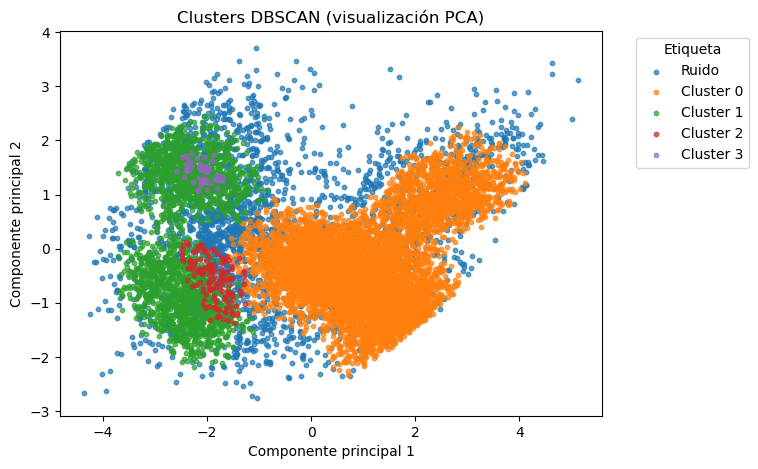

In [89]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducimos a 2 dimensiones con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_db.values)

plt.figure(figsize=(7,5))

# graficamos cada cluster por separado con su etiqueta
unique_clusters = sorted(df_dbscan["cluster_dbscan"].unique())

for c in unique_clusters:
    mask = df_dbscan["cluster_dbscan"] == c
    nombre = "Ruido" if c == -1 else f"Cluster {c}"
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=10, alpha=0.7, label=nombre)

plt.title("Clusters DBSCAN (visualización PCA)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Etiqueta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

La proyección con pca muestra que los clusters detectados no están perfectamente separados y tienden a mezclarse en los bordes. Esto confirma lo que ya anticipaban las métricas: la estructura de los datos no es muy marcada. Aun así, el algoritmo alcanzó a diferenciar cuatro grupos principales más un conjunto de puntos considerados ruido.

Al revisar el perfil promedio de cada cluster se observan diferencias sutiles:

- El cluster 0 reúne granos con área y diámetro algo menores, y redondez más alta.

- El cluster 1 concentra granos de mayor área y diámetro, con excentricidad elevada.

- El cluster 2 muestra valores intermedios en área y diámetro, pero excentricidad también alta.

- El cluster 3 corresponde a los granos de mayor área y diámetro promedio, aunque con redondez algo menor.

- Los puntos marcados como ruido mantienen valores intermedios, lo que sugiere que no encajan de manera clara en ninguno de los grupos.

en conjunto, aunque la separación no es nítida, dbscan ofrece una primera segmentación que permite comparar perfiles morfológicos y resalta que una fracción considerable de los granos se comporta de forma atípica.

#### 4.2.6 Conclusiones

Los resultados de DBSCAN muestran que el algoritmo fue capaz de identificar cuatro grupos principales en los datos, además de un conjunto considerable de observaciones tratadas como ruido. Aunque la calidad de los clusters no es muy alta, sí se alcanzan a percibir diferencias en el perfil promedio de cada grupo, sobre todo en las variables de Área, Diámetro y Excentricidad.

- El algoritmo aisló cerca del 22% de los puntos como ruido, lo que refleja que una parte importante de los granos no sigue patrones claros.

- Los cuatro clusters detectados presentan diferencias graduales: desde granos con Área y Diámetro menores hasta grupos con granos mucho más grandes y excéntricos.

- Las métricas (Silueta y Davies–Bouldin) confirman que los clusters no están fuertemente separados y mantienen solapamientos, pero aun así se reconoce cierta estructura en los datos.

En conclusión, DBSCAN no ofrece una separación contundente, pero sí aporta valor al resaltar la presencia de varios perfiles morfológicos y al señalar un conjunto de observaciones atípicas que podrían ser relevantes para la empresa en procesos de Control de Calidad y Selección.

### 4.3 Algoritmo est 3

## 5. Comparación entre modelos